In [2]:
import numpy
from PIL import Image

In [3]:
import sys
import os.path

In [4]:
import sys, os
sys.path.append("../..")
import numpy as np
try:
    from PIL import Image
except ImportError:
    import Image

In [5]:
image = Image.open('orl_faces/s1/1.pgm')

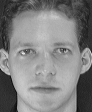

In [6]:
image

In [7]:
img_ndarray = numpy.asarray(image, dtype='float64')/256

In [8]:
img_ndarray.shape

(112, 92)

In [9]:
img_ndarray.ndim

2

In [10]:
def read_images(path, sz=None):
    """Reads the images in a given folder, resizes images on the fly if size is given.
    Args:
        path: Path to a folder with subfolders representing the subjects (persons).
        sz: A tuple with the size Resizes 
    Returns:
        A list [X,y]
            X: The images, which is a Python list of numpy arrays.
            y: The corresponding labels (the unique number of the subject, person) in a Python list.
    """
    c = 0
    X,y = [], []
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                    im = Image.open(os.path.join(subject_path, filename))
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    X.append(np.asarray(im, dtype=np.uint8))
                    y.append(c)
            c = c+1
    return [X,y]

In [11]:
def asColumnMatrix(X):
    """
    Creates a column-matrix from multi-dimensional data items in list l.
    
    X [list] List with multi-dimensional data.
    """
    if len(X) == 0:
        return np.array([])
    total = 1
    for i in range(0, np.ndim(X[0])):
        total = total * X[0].shape[i]
    mat = np.empty([total, 0], dtype=X[0].dtype)
    for col in X:
        mat = np.append(mat, col.reshape(-1,1), axis=1) # same as hstack
    return np.asmatrix(mat)

In [12]:
X ,Y = read_images('orl_faces')

In [13]:
class AbstractFeature(object):

    def compute(self,X,y):
        raise NotImplementedError("Every AbstractFeature must implement the compute method.")
    
    def extract(self,X):
        raise NotImplementedError("Every AbstractFeature must implement the extract method.")
        
    def save(self):
        raise NotImplementedError("Not implemented yet (TODO).")
    
    def load(self):
        raise NotImplementedError("Not implemented yet (TODO).")
        
    def __repr__(self):
        return "AbstractFeature"

class Identity(AbstractFeature):
    """
    Simplest AbstractFeature you could imagine. It only forwards the data and does not operate on it, 
    probably useful for learning a Support Vector Machine on raw data for example!
    """
    def __init__(self):
        AbstractFeature.__init__(self)
        
    def compute(self,X,y):
        return X
    
    def extract(self,X):
        return X
    
    def __repr__(self):
        return "Identity"

In [65]:
XC = asColumnMatrix(X)

In [70]:
XC

matrix([[ 48,  34,  60, ..., 112, 111, 110],
        [ 49,  34,  60, ..., 109, 114, 112],
        [ 45,  33,  62, ..., 116, 112, 113],
        ..., 
        [ 47,  37,  32, ...,  93,  88,  92],
        [ 46,  40,  34, ...,  88,  86,  87],
        [ 46,  33,  34, ...,  92,  92,  90]], dtype=uint8)

In [14]:
class PCA(AbstractFeature):
    def __init__(self, num_components=0):
        AbstractFeature.__init__(self)
        self._num_components = num_components
        
    def compute(self,X,y):
        # build the column matrix
        XC = asColumnMatrix(X)
        y = np.asarray(y)
        # set a valid number of components
        if self._num_components <= 0 or (self._num_components > XC.shape[1]-1):
            self._num_components = XC.shape[1]-1
        # center dataset
        self._mean = XC.mean(axis=1).reshape(-1,1)
        XC = XC - self._mean
        # perform an economy size decomposition (may still allocate too much memory for computation)
        self._eigenvectors, self._eigenvalues, variances = np.linalg.svd(XC, full_matrices=False)
        # sort eigenvectors by eigenvalues in descending order
        idx = np.argsort(-self._eigenvalues)
        self._eigenvalues, self._eigenvectors = self._eigenvalues[idx], self._eigenvectors[:,idx]
        # use only num_components
        self._eigenvectors = self._eigenvectors[0:,0:self._num_components].copy()
        self._eigenvalues = self._eigenvalues[0:self._num_components].copy()
        # finally turn singular values into eigenvalues 
        self._eigenvalues = np.power(self._eigenvalues,2) / XC.shape[1]
        # get the features from the given data
        features = []
        for x in X:
            xp = self.project(x.reshape(-1,1))
            features.append(xp)
        return features
    
    def extract(self,X):
        X = np.asarray(X).reshape(-1,1)
        return self.project(X)
        
    def project(self, X):
        X = X - self._mean
        return np.dot(self._eigenvectors.T, X)

    def reconstruct(self, X):
        X = np.dot(self._eigenvectors, X)
        return X + self._mean

    @property
    def num_components(self):
        return self._num_components

    @property
    def eigenvalues(self):
        return self._eigenvalues
        
    @property
    def eigenvectors(self):
        return self._eigenvectors

    @property
    def mean(self):
        return self._mean
        
    def __repr__(self):
        return "PCA (num_components=%d)" % (self._num_components)

In [15]:
class LDA(AbstractFeature):

    def __init__(self, num_components=0):
        AbstractFeature.__init__(self)
        self._num_components = num_components

    def compute(self, X, y):
        # build the column matrix
        XC = asColumnMatrix(X)
        y = np.asarray(y)
        # calculate dimensions
        d = XC.shape[0]
        c = len(np.unique(y))        
        # set a valid number of components
        if self._num_components <= 0:
            self._num_components = c-1
        elif self._num_components > (c-1):
            self._num_components = c-1
        # calculate total mean
        meanTotal = XC.mean(axis=1).reshape(-1,1)
        # calculate the within and between scatter matrices
        Sw = np.zeros((d, d), dtype=np.float32)
        Sb = np.zeros((d, d), dtype=np.float32)
        for i in range(0,c):
            Xi = XC[:,np.where(y==i)[0]]
            meanClass = np.mean(Xi, axis = 1).reshape(-1,1)
            Sw = Sw + np.dot((Xi-meanClass), (Xi-meanClass).T)
            Sb = Sb + Xi.shape[1] * np.dot((meanClass - meanTotal), (meanClass - meanTotal).T)
        # solve eigenvalue problem for a general matrix
        self._eigenvalues, self._eigenvectors = np.linalg.eig(np.linalg.inv(Sw)*Sb)
        # sort eigenvectors by their eigenvalue in descending order
        idx = np.argsort(-self._eigenvalues.real)
        self._eigenvalues, self._eigenvectors = self._eigenvalues[idx], self._eigenvectors[:,idx]
        # only store (c-1) non-zero eigenvalues
        self._eigenvalues = np.array(self._eigenvalues[0:self._num_components].real, dtype=np.float32, copy=True)
        self._eigenvectors = np.matrix(self._eigenvectors[0:,0:self._num_components].real, dtype=np.float32, copy=True)
        # get the features from the given data
        features = []
        for x in X:
            xp = self.project(x.reshape(-1,1))
            features.append(xp)
        return features
        
    def project(self, X):
        return np.dot(self._eigenvectors.T, X)

    def reconstruct(self, X):
        return np.dot(self._eigenvectors, X)

    @property
    def num_components(self):
        return self._num_components

    @property
    def eigenvectors(self):
        return self._eigenvectors
    
    @property
    def eigenvalues(self):
        return self._eigenvalues
    
    def __repr__(self):
        return "LDA (num_components=%d)" % (self._num_components)

In [16]:
class Fisherfaces(AbstractFeature):

    def __init__(self, num_components=0):
        AbstractFeature.__init__(self)
        self._num_components = num_components
    
    def compute(self, X, y):
        # turn into numpy representation
        Xc = asColumnMatrix(X)
        y = np.asarray(y)
        # gather some statistics about the dataset
        n = len(y)
        c = len(np.unique(y))
        # define features to be extracted
        pca = PCA(num_components = (n-c))
        lda = LDA(num_components = self._num_components)
        # fisherfaces are a chained feature of PCA followed by LDA
        model = ChainOperator(pca,lda)
        # computing the chained model then calculates both decompositions
        model.compute(X,y)
        # store eigenvalues and number of components used
        self._eigenvalues = lda.eigenvalues
        self._num_components = lda.num_components
        # compute the new eigenspace as pca.eigenvectors*lda.eigenvectors
        self._eigenvectors = np.dot(pca.eigenvectors,lda.eigenvectors)
        # finally compute the features (these are the Fisherfaces)
        features = []
        for x in X:
            xp = self.project(x.reshape(-1,1))
            features.append(xp)
        return features

    def extract(self,X):
        X = np.asarray(X).reshape(-1,1)
        return self.project(X)

    def project(self, X):
        return np.dot(self._eigenvectors.T, X)
    
    def reconstruct(self, X):
        return np.dot(self._eigenvectors, X)

    @property
    def num_components(self):
        return self._num_components
        
    @property
    def eigenvalues(self):
        return self._eigenvalues
    
    @property
    def eigenvectors(self):
        return self._eigenvectors

    def __repr__(self):
        return "Fisherfaces (num_components=%s)" % (self.num_components)

In [17]:
feature = Fisherfaces()

In [18]:
feature

Fisherfaces (num_components=0)

In [19]:
class AbstractClassifier(object):

    def compute(self,X,y):
        raise NotImplementedError("Every AbstractClassifier must implement the compute method.")
    
    def predict(self,X):
        raise NotImplementedError("Every AbstractClassifier must implement the predict method.")

    def update(self,X,y):
        raise NotImplementedError("This Classifier is cannot be updated.")


In [20]:
class AbstractDistance(object):
    def __init__(self, name):
        self._name = name
        
    def __call__(self,p,q):
        raise NotImplementedError("Every AbstractDistance must implement the __call__ method.")
        
    @property
    def name(self):
        return self._name

    def __repr__(self):
        return self._name

In [21]:
class EuclideanDistance(AbstractDistance):
    def __init__(self):
        AbstractDistance.__init__(self,"EuclideanDistance")

    def __call__(self, p, q):
        p = np.asarray(p).flatten()
        q = np.asarray(q).flatten()
        return np.sqrt(np.sum(np.power((p-q),2)))

In [22]:
class NearestNeighbor(AbstractClassifier):
    """
    Implements a k-Nearest Neighbor Model with a generic distance metric.
    """
    def __init__(self, dist_metric=EuclideanDistance(), k=1):
        AbstractClassifier.__init__(self)
        self.k = k
        self.dist_metric = dist_metric
        self.X = []
        self.y = np.array([], dtype=np.int32)

    def update(self, X, y):
        """
        Updates the classifier.
        """
        self.X.append(X)
        self.y = np.append(self.y, y)

    def compute(self, X, y):
        self.X = X
        self.y = np.asarray(y)
    
    def predict(self, q):
        """
        Predicts the k-nearest neighbor for a given query in q. 
        
        Args:
        
            q: The given query sample, which is an array.
            
        Returns:
        
            A list with the classifier output. In this framework it is
            assumed, that the predicted class is always returned as first
            element. Moreover, this class returns the distances for the 
            first k-Nearest Neighbors. 
            
            Example:
            
                [ 0, 
                   { 'labels'    : [ 0,      0,      1      ],
                     'distances' : [ 10.132, 10.341, 13.314 ]
                   }
                ]
            
            So if you want to perform a thresholding operation, you could 
            pick the distances in the second array of the generic classifier
            output.    
                    
        """
        distances = []
        for xi in self.X:
            xi = xi.reshape(-1,1)
            d = self.dist_metric(xi, q)
            distances.append(d)
        if len(distances) > len(self.y):
            raise Exception("More distances than classes. Is your distance metric correct?")
        distances = np.asarray(distances)
        # Get the indices in an ascending sort order:
        idx = np.argsort(distances)
        # Sort the labels and distances accordingly:
        sorted_y = self.y[idx]
        sorted_distances = distances[idx]
        # Take only the k first items:
        sorted_y = sorted_y[0:self.k]
        sorted_distances = sorted_distances[0:self.k]
        # Make a histogram of them:
        hist = dict((key,val) for key, val in enumerate(np.bincount(sorted_y)) if val)
        # And get the bin with the maximum frequency:
        predicted_label = max(hist.items(), key=op.itemgetter(1))[0]
        # A classifier should output a list with the label as first item and
        # generic data behind. The k-nearest neighbor classifier outputs the 
        # distance of the k first items. So imagine you have a 1-NN and you
        # want to perform a threshold against it, you should take the first
        # item 
        return [predicted_label, { 'labels' : sorted_y, 'distances' : sorted_distances }]
        
    def __repr__(self):
        return "NearestNeighbor (k=%s, dist_metric=%s)" % (self.k, repr(self.dist_metric))

In [23]:
class PredictableModel(object):
    def __init__(self, feature, classifier):
        if not isinstance(feature, AbstractFeature):
            raise TypeError("feature must be of type AbstractFeature!")
        if not isinstance(classifier, AbstractClassifier):
            raise TypeError("classifier must be of type AbstractClassifier!")
        
        self.feature = feature
        self.classifier = classifier
    
    def compute(self, X, y):
        features = self.feature.compute(X,y)
        self.classifier.compute(features,y)

    def predict(self, X):
        q = self.feature.extract(X)
        return self.classifier.predict(q)
        
    def __repr__(self):
        feature_repr = repr(self.feature)
        classifier_repr = repr(self.classifier)
        return "PredictableModel (feature=%s, classifier=%s)" % (feature_repr, classifier_repr)

In [24]:
def asColumnMatrix(X):
    """
    Creates a column-matrix from multi-dimensional data items in list l.
    
    X [list] List with multi-dimensional data.
    """
    if len(X) == 0:
        return np.array([])
    total = 1
    for i in range(0, np.ndim(X[0])):
        total = total * X[0].shape[i]
    mat = np.empty([total, 0], dtype=X[0].dtype)
    for col in X:
        mat = np.append(mat, col.reshape(-1,1), axis=1) # same as hstack
    return np.asmatrix(mat)

In [25]:
class FeatureOperator(AbstractFeature):
    """
    A FeatureOperator operates on two feature models.
    
    Args:
        model1 [AbstractFeature]
        model2 [AbstractFeature]
    """
    def __init__(self,model1,model2):
        if (not isinstance(model1,AbstractFeature)) or (not isinstance(model2,AbstractFeature)):
            raise Exception("A FeatureOperator only works on classes implementing an AbstractFeature!")
        self.model1 = model1
        self.model2 = model2
    
    def __repr__(self):
        return "FeatureOperator(" + repr(self.model1) + "," + repr(self.model2) + ")"

In [26]:
class ChainOperator(FeatureOperator):
    """
    The ChainOperator chains two feature extraction modules:
        model2.compute(model1.compute(X,y),y)
    Where X can be generic input data.
    
    Args:
        model1 [AbstractFeature]
        model2 [AbstractFeature]
    """
    def __init__(self,model1,model2):
        FeatureOperator.__init__(self,model1,model2)
        
    def compute(self,X,y):
        X = self.model1.compute(X,y)
        return self.model2.compute(X,y)
        
    def extract(self,X):
        X = self.model1.extract(X)
        return self.model2.extract(X)
    
    def __repr__(self):
        return "ChainOperator(" + repr(self.model1) + "," + repr(self.model2) + ")"

In [27]:
import numpy as np
import math as math
import random as random
import logging
import operator as op

In [28]:
class ValidationStrategy(object):
    """ Represents a generic Validation kernel for all Validation strategies.
    """
    def __init__(self, model):
        """    
        Initialize validation with empty results.
        
        Args:
        
            model [PredictableModel] The model, which is going to be validated.
        """
        if not isinstance(model,PredictableModel):
            raise TypeError("Validation can only validate the type PredictableModel.")
        self.model = model
        self.validation_results = []
    
    def add(self, validation_result):
        self.validation_results.append(validation_result)
        
    def validate(self, X, y, description):
        """
        
        Args:
            X [list] Input Images
            y [y] Class Labels
            description [string] experiment description
        
        """
        raise NotImplementedError("Every Validation module must implement the validate method!")
        
    
    def print_results(self):
        print(self.model)
        for validation_result in self.validation_results:
            print(validation_result)

    def __repr__(self):
        return "Validation Kernel (model=%s)" % (self.model)

In [29]:
class KFoldCrossValidation(ValidationStrategy):
    """ 
    
    Divides the Data into 10 equally spaced and non-overlapping folds for training and testing.
    
    Here is a 3-fold cross validation example for 9 observations and 3 classes, so each observation is given by its index [c_i][o_i]:
                
        o0 o1 o2        o0 o1 o2        o0 o1 o2  
    c0 | A  B  B |  c0 | B  A  B |  c0 | B  B  A |
    c1 | A  B  B |  c1 | B  A  B |  c1 | B  B  A |
    c2 | A  B  B |  c2 | B  A  B |  c2 | B  B  A |
    
    Please note: If there are less than k observations in a class, k is set to the minimum of observations available through all classes.
    """
    def __init__(self, model, k=10):
        """
        Args:
            k [int] number of folds in this k-fold cross-validation (default 10)
        """
        super(KFoldCrossValidation, self).__init__(model=model)
        self.k = k
        self.logger = logging.getLogger("facerec.validation.KFoldCrossValidation")

    def validate(self, X, y, description="ExperimentName"):
        """ Performs a k-fold cross validation
        
        Args:
            X [dim x num_data] input data to validate on
            y [1 x num_data] classes
        """
        X,y = shuffle(X,y)
        c = len(np.unique(y))
        foldIndices = []
        n = np.iinfo(np.int).max
        for i in range(0,c):
            idx = np.where(y==i)[0]
            n = min(n, idx.shape[0])
            foldIndices.append(idx.tolist()); 

        # I assume all folds to be of equal length, so the minimum
        # number of samples in a class is responsible for the number
        # of folds. This is probably not desired. Please adjust for
        # your use case.
        if n < self.k:
            self.k = n

        foldSize = int(math.floor(n/self.k))
        
        true_positives, false_positives, true_negatives, false_negatives = (0,0,0,0)
        for i in range(0,self.k):
        
            self.logger.info("Processing fold %d/%d." % (i+1, self.k))
                
            # calculate indices
            l = int(i*foldSize)
            h = int((i+1)*foldSize)
            testIdx = slice_2d(foldIndices, cols=range(l,h), rows=range(0, c))
            trainIdx = slice_2d(foldIndices,cols=range(0,l), rows=range(0,c))
            trainIdx.extend(slice_2d(foldIndices,cols=range(h,n),rows=range(0,c)))
            
            # build training data subset
            Xtrain = [X[t] for t in trainIdx]
            ytrain = y[trainIdx]
                        
            self.model.compute(Xtrain, ytrain)
            
            # TODO I have to add the true_negatives and false_negatives. Models also need to support it,
            # so we should use a PredictionResult, instead of trying to do this by simply comparing
            # the predicted and actual class.
            #
            # This is inteneded of the next version! Feel free to contribute.
            for j in testIdx:
                prediction = self.model.predict(X[j])[0]
                if prediction == y[j]:
                    true_positives = true_positives + 1
                else:
                    false_positives = false_positives + 1
                    
        self.add(ValidationResult(true_positives, true_negatives, false_positives, false_negatives, description))
    
    def __repr__(self):
        return "k-Fold Cross Validation (model=%s, k=%s)" % (self.model, self.k)

In [30]:
def shuffle(X, y):
    """ Shuffles two arrays by column (len(X) == len(y))
        
        Args:
        
            X [dim x num_data] input data
            y [1 x num_data] classes
        Returns:
            Shuffled input arrays.
    """
    idx = np.argsort([random.random() for i in range(len(y))])
    y = np.asarray(y)
    X = [X[i] for i in idx]
    y = y[idx]
    return (X, y)

In [31]:
def slice_2d(X,rows,cols):
    """
    
    Slices a 2D list to a flat array. If you know a better approach, please correct this.
    
    Args:
    
        X [num_rows x num_cols] multi-dimensional data
        rows [list] rows to slice
        cols [list] cols to slice
    
    Example:
    
        >>> X=[[1,2,3,4],[5,6,7,8]]
        >>> # slice first two rows and first column
        >>> Commons.slice(X, range(0,2), range(0,1)) # returns [1, 5]
        >>> Commons.slice(X, range(0,1), range(0,4)) # returns [1,2,3,4]
    """
    return [X[i][j] for j in cols for i in rows]

In [32]:
class ValidationResult(object):
    """Holds a validation result.
    """
    def __init__(self, true_positives, true_negatives, false_positives, false_negatives, description):
        self.true_positives = true_positives
        self.true_negatives = true_negatives
        self.false_positives = false_positives
        self.false_negatives = false_negatives
        self.description = description
        
    def __repr__(self):
        res_precision = precision(self.true_positives, self.false_positives) * 100
        res_accuracy = accuracy(self.true_positives, self.true_negatives, self.false_positives, self.false_negatives) * 100
        return "ValidationResult (Description=%s, Precision=%.2f%%, Accuracy=%.2f%%)" % (self.description, res_precision, res_accuracy)

In [33]:
def precision(true_positives, false_positives):
    """Returns the precision, calculated as:
        
        true_positives/(true_positives+false_positives)
        
    """
    return accuracy(true_positives, 0, false_positives, 0)
    
def accuracy(true_positives, true_negatives, false_positives, false_negatives, description=None):
    """Returns the accuracy, calculated as:
    
        (true_positives+true_negatives)/(true_positives+false_positives+true_negatives+false_negatives)
        
    """
    true_positives = float(true_positives)
    true_negatives = float(true_negatives)
    false_positives = float(false_positives)
    false_negatives = float(false_negatives)
    if (true_positives + true_negatives + false_positives + false_negatives) < 1e-15:
       return 0.0
    return (true_positives+true_negatives)/(true_positives+false_positives+true_negatives+false_negatives)

In [98]:
classifier = NearestNeighbor(dist_metric=EuclideanDistance(), k=7)

In [99]:
my_model = PredictableModel(feature=feature, classifier=classifier)

In [100]:
my_model.compute(X, Y)

In [101]:
cv = KFoldCrossValidation(my_model, k=10)

In [102]:
cv.validate(X, Y)

In [97]:
cv.print_results()

PredictableModel (feature=Fisherfaces (num_components=39), classifier=NearestNeighbor (k=6, dist_metric=EuclideanDistance))
ValidationResult (Description=ExperimentName, Precision=96.50%, Accuracy=96.50%)
